# Test the pathline code

In [1]:
import numpy as np
import pylab as plt
import xarray as xr
from pypism.trajectory import compute_trajectory, trajectories_to_geopandas
from pypism.interpolation import velocity_at_point
from shapely import Point
from osgeo import ogr, osr
from joblib import Parallel, delayed
import geopandas as gp
from typing import Union
from tqdm.auto import tqdm
import pandas as pd

/Users/andy/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [115]:
def create_circular() -> xr.Dataset:
    """
    Create xr.Dataset with radial velocity field
    """
    time = pd.date_range("2000-01-01", periods=1)
    reference_time = pd.Timestamp("2000-01-01")

    nx = 20_001
    ny = 20_001
    x = np.linspace(-100e3, 100e3, nx)
    y = np.linspace(-100e3, 100e3, ny)
    X, Y = np.meshgrid(x, y)

    # Directional vectors
    vx = -Y / np.sqrt(X**2 + Y**2) * 250
    vy = X / np.sqrt(X**2 + Y**2) * 250
    v = np.sqrt(vx**2 + vy**2)

    vx = vx.reshape(1, ny, nx)
    vy = vy.reshape(1, ny, nx)
    v = v.reshape(1, ny, nx)

    v_err = v / 10
    vx_err = np.abs(vx / 20)
    vy_err = np.abs(vy / 20)

    coords = {
        "x": (
            ["x"],
            x,
            {
                "units": "m",
                "axis": "X",
                "standard_name": "projection_x_coordinate",
                "long_name": "x-coordinate in projected coordinate system",
            },
        ),
        "y": (
            ["y"],
            y,
            {
                "units": "m",
                "axis": "Y",
                "standard_name": "projection_y_coordinate",
                "long_name": "y-coordinate in projected coordinate system",
            },
        ),
        "time": (["time"], time, {}),
    }

    ds = xr.Dataset(
        {
            "vx": xr.DataArray(
                data=vx,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in x-direction", "units": "m/yr"},
            ),
            "vy": xr.DataArray(
                data=vy,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in y-direction", "units": "m/yr"},
            ),
            "v": xr.DataArray(
                data=v,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={
                    "standard_name": "magnitude",
                    "units": "m/yr",
                    "grid_mapping": "polar_stereographic",
                },
            ),
            "vx_err": xr.DataArray(
                data=vx_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in x-direction", "units": "m/yr"},
            ),
            "vy_err": xr.DataArray(
                data=vy_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in y-direction", "units": "m/yr"},
            ),
            "v_err": xr.DataArray(
                data=v_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={
                    "standard_name": "magnitude",
                    "units": "m/yr",
                    "grid_mapping": "polar_stereographic",
                },
            ),
        },
        attrs={"Conventions": "CF-1.7"},
    )
    ds["Polar_Stereographic"] = int()
    ds.Polar_Stereographic.attrs["grid_mapping_name"] = "polar_stereographic"
    ds.Polar_Stereographic.attrs["false_easting"] = 0.0
    ds.Polar_Stereographic.attrs["false_northing"] = 0.0
    ds.Polar_Stereographic.attrs["latitude_of_projection_origin"] = 90.0
    ds.Polar_Stereographic.attrs["scale_factor_at_projection_origin"] = 1.0
    ds.Polar_Stereographic.attrs["standard_parallel"] = 70.0
    ds.Polar_Stereographic.attrs["straight_vertical_longitude_from_pole"] = -45
    ds.Polar_Stereographic.attrs["proj_params"] = "epsg:3413"
    
    return ds


In [116]:
ds = create_circular()
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())
V = np.squeeze(ds["v"].to_numpy())
x = ds["x"].to_numpy()
y = ds["y"].to_numpy()
nx = len(x)
ny = len(y)

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_37893/593437922.py:15: RuntimeWarning: invalid value encountered in divide
  vx = -Y / np.sqrt(X**2 + Y**2) * 250
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_37893/593437922.py:16: RuntimeWarning: invalid value encountered in divide
  vy = X / np.sqrt(X**2 + Y**2) * 250


## Create doc-string examples

In [ ]:
import numpy as np
from shapely import Point

nx = 201
ny = 401
x = np.linspace(-100e3, 100e3, nx)
y = np.linspace(-100e3, 100e3, ny)
X, Y = np.meshgrid(x, y)

# Directional vectors
vx = -Y / np.sqrt(X**2 + Y**2) * 250
vy = X / np.sqrt(X**2 + Y**2) * 250

p = Point(0, -50000)

pts, pts_error_estim = compute_trajectory(p, vx, vx, x, y, dt=1, total_time=10)

In [9]:
dt_trajs[0][0]

([<POINT (0 -25000)>,
  <POINT (-2.5 -25000)>,
  <POINT (-5 -25000)>,
  <POINT (-7.5 -24999.999)>,
  <POINT (-10 -24999.998)>,
  <POINT (-12.5 -24999.997)>,
  <POINT (-15 -24999.996)>,
  <POINT (-17.5 -24999.994)>,
  <POINT (-20 -24999.992)>,
  <POINT (-22.5 -24999.99)>,
  <POINT (-25 -24999.988)>,
  <POINT (-27.5 -24999.985)>,
  <POINT (-30 -24999.982)>,
  <POINT (-32.5 -24999.979)>,
  <POINT (-35 -24999.976)>,
  <POINT (-37.499 -24999.972)>,
  <POINT (-39.999 -24999.968)>,
  <POINT (-42.499 -24999.964)>,
  <POINT (-44.999 -24999.96)>,
  <POINT (-47.499 -24999.955)>,
  <POINT (-49.999 -24999.95)>,
  <POINT (-52.499 -24999.945)>,
  <POINT (-54.999 -24999.94)>,
  <POINT (-57.499 -24999.934)>,
  <POINT (-59.999 -24999.928)>,
  <POINT (-62.498 -24999.922)>,
  <POINT (-64.998 -24999.916)>,
  <POINT (-67.498 -24999.909)>,
  <POINT (-69.998 -24999.902)>,
  <POINT (-72.498 -24999.895)>,
  <POINT (-74.998 -24999.888)>,
  <POINT (-77.498 -24999.88)>,
  <POINT (-79.997 -24999.872)>,
  <POINT (-8

In [117]:
starting_point = Point(0, -1_000)
r = starting_point.distance(Point(0, 0))
circ = 2 * r * np.pi
vx, vy = velocity_at_point(Vx, Vy, x, y, starting_point)
v = np.sqrt(vx**2 + vy**2)
total_time = circ / v    

dts = np.logspace(-3, 2, 6)
dt_trajs = {}

progress = tqdm(dts, total=len(dts), leave=False, position=0)
for dt in progress:
    progress.set_description(f"Time step {dt}")
    pts, pts_error_estim = compute_trajectory(starting_point, Vx, Vy, x, y, total_time=total_time+dt, dt=dt, reverse=True)
    dt_trajs[dt] = pts


Time step 0.001:   0%|                                                                                                                           | 0/6 [00:00<?, ?it/s]
Integration trajectory:   0%|                                                                                                   | 0/25.133741228718346 [00:00<?, ?it/s]
Integration trajectory:   0%|▎                                                                        | 0.10800000000000008/25.133741228718346 [00:00<00:23,  1.08it/s]
Integration trajectory:   1%|▋                                                                        | 0.21900000000000017/25.133741228718346 [00:00<00:22,  1.09it/s]
Integration trajectory:   1%|▉                                                                        | 0.32900000000000024/25.133741228718346 [00:00<00:22,  1.09it/s]
Integration trajectory:   2%|█▎                                                                       | 0.43900000000000033/25.133741228718346 [00:00<00:22,  1.

Integration trajectory:  20%|███████████████▏                                                           | 5.083000000000032/25.133741228718346 [00:04<00:18,  1.10it/s]
Integration trajectory:  21%|███████████████▍                                                           | 5.193000000000069/25.133741228718346 [00:04<00:18,  1.10it/s]
Integration trajectory:  21%|███████████████▊                                                           | 5.304000000000106/25.133741228718346 [00:04<00:18,  1.10it/s]
Integration trajectory:  22%|████████████████▏                                                          | 5.415000000000143/25.133741228718346 [00:04<00:17,  1.10it/s]
Integration trajectory:  22%|████████████████▋                                                           | 5.52500000000018/25.133741228718346 [00:05<00:17,  1.10it/s]
Integration trajectory:  22%|████████████████▊                                                          | 5.636000000000217/25.133741228718346 [00:05<00:17,  1.

Integration trajectory:  41%|██████████████████████████████▏                                           | 10.237999999999765/25.133741228718346 [00:09<00:13,  1.08it/s]
Integration trajectory:  41%|██████████████████████████████▍                                           | 10.347999999999704/25.133741228718346 [00:09<00:13,  1.08it/s]
Integration trajectory:  42%|██████████████████████████████▊                                           | 10.458999999999643/25.133741228718346 [00:09<00:13,  1.09it/s]
Integration trajectory:  42%|███████████████████████████████                                           | 10.567999999999582/25.133741228718346 [00:09<00:13,  1.09it/s]
Integration trajectory:  42%|███████████████████████████████▊                                           | 10.67899999999952/25.133741228718346 [00:09<00:13,  1.09it/s]
Integration trajectory:  43%|███████████████████████████████▊                                          | 10.790999999999459/25.133741228718346 [00:09<00:13,  1.

Integration trajectory:  62%|█████████████████████████████████████████████▌                            | 15.492999999996853/25.133741228718346 [00:14<00:08,  1.11it/s]
Integration trajectory:  62%|██████████████████████████████████████████████▌                            | 15.60499999999679/25.133741228718346 [00:14<00:08,  1.11it/s]
Integration trajectory:  63%|██████████████████████████████████████████████▎                           | 15.716999999996728/25.133741228718346 [00:14<00:08,  1.11it/s]
Integration trajectory:  63%|██████████████████████████████████████████████▌                           | 15.827999999996667/25.133741228718346 [00:14<00:08,  1.11it/s]
Integration trajectory:  63%|██████████████████████████████████████████████▉                           | 15.939999999996605/25.133741228718346 [00:14<00:08,  1.11it/s]
Integration trajectory:  64%|███████████████████████████████████████████████▎                          | 16.052999999996636/25.133741228718346 [00:14<00:08,  1.

Integration trajectory:  83%|█████████████████████████████████████████████████████████████▉             | 20.75400000000238/25.133741228718346 [00:18<00:03,  1.11it/s]
Integration trajectory:  83%|██████████████████████████████████████████████████████████████▎            | 20.86600000000252/25.133741228718346 [00:18<00:03,  1.11it/s]
Integration trajectory:  83%|█████████████████████████████████████████████████████████████▊            | 20.979000000002657/25.133741228718346 [00:19<00:03,  1.12it/s]
Integration trajectory:  84%|██████████████████████████████████████████████████████████████            | 21.092000000002795/25.133741228718346 [00:19<00:03,  1.12it/s]
Integration trajectory:  84%|██████████████████████████████████████████████████████████████▍           | 21.205000000002933/25.133741228718346 [00:19<00:03,  1.12it/s]
Integration trajectory:  85%|███████████████████████████████████████████████████████████████▌           | 21.31800000000307/25.133741228718346 [00:19<00:03,  1.

Integration trajectory:  27%|███████████████████▉                                                       | 6.679999999999902/25.142741228718346 [00:00<00:01, 11.07it/s]
Integration trajectory:  31%|███████████████████████▏                                                   | 7.789999999999878/25.142741228718346 [00:00<00:01, 11.05it/s]
Integration trajectory:  35%|██████████████████████████▌                                                | 8.909999999999854/25.142741228718346 [00:00<00:01, 11.06it/s]
Integration trajectory:  40%|█████████████████████████████▉                                             | 10.02999999999983/25.142741228718346 [00:00<00:01, 11.08it/s]
Integration trajectory:  44%|████████████████████████████████▊                                         | 11.139999999999807/25.142741228718346 [00:01<00:01, 11.06it/s]
Integration trajectory:  49%|████████████████████████████████████                                      | 12.249999999999783/25.142741228718346 [00:01<00:01, 11.

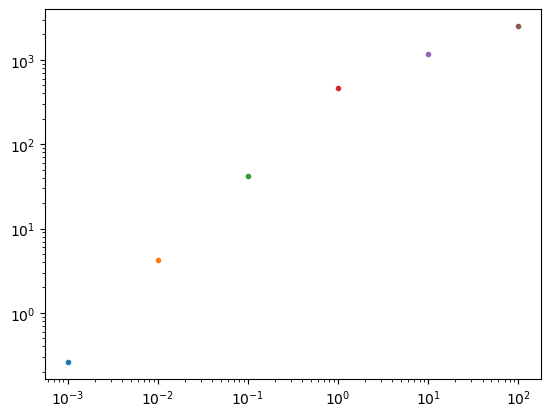

In [118]:
fig, ax = plt.subplots(1, 1)
dists =[]
for dt, traj in dt_trajs.items():
    dist = traj[-1].distance(traj[0])
    dists.append(dist)
    ax.plot(dt, dist, ".")
    ax.set_xscale("log")
    ax.set_yscale("log")
dists = np.array(dists)

In [119]:
np.diff(dists) / dists[1:]

array([0.93845483, 0.8979241 , 0.90972299, 0.60469157, 0.5369995 ])

In [113]:
dists[1:]

array([9.55137544e-01, 3.65152195e+01, 4.57463776e+02, 1.14790363e+03,
       2.52722848e+03])

In [114]:
dts

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [32]:
vx

250.0

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [85]:
traj

[<POINT (0 -25000)>,
 <POINT (-21045.868 -13497.942)>,
 <POINT (-22728.989 10428.574)>,
 <POINT (-3497.216 24763.925)>]

In [129]:
def create_linear() -> xr.Dataset:
    """
    Create xr.Dataset with radial velocity field
    """
    time = pd.date_range("2000-01-01", periods=1)
    reference_time = pd.Timestamp("2000-01-01")

    nx = 2_001
    ny = 2_001
    x_min = -100_000
    x_max = 100_000
    y_min = -100_000
    y_max = 100_000
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(x, y)

    # Directional vectors
    vx = (X - x_min) / 1_000
    vy = (Y - y_min) / 1_000
    v = np.sqrt(vx**2 + vy**2)

    vx = vx.reshape(1, ny, nx)
    vy = vy.reshape(1, ny, nx)
    v = v.reshape(1, ny, nx)

    v_err = v / 10
    vx_err = np.abs(vx / 20)
    vy_err = np.abs(vy / 20)

    coords = {
        "x": (
            ["x"],
            x,
            {
                "units": "m",
                "axis": "X",
                "standard_name": "projection_x_coordinate",
                "long_name": "x-coordinate in projected coordinate system",
            },
        ),
        "y": (
            ["y"],
            y,
            {
                "units": "m",
                "axis": "Y",
                "standard_name": "projection_y_coordinate",
                "long_name": "y-coordinate in projected coordinate system",
            },
        ),
        "time": (["time"], time, {}),
    }

    ds = xr.Dataset(
        {
            "vx": xr.DataArray(
                data=vx,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in x-direction", "units": "m/yr"},
            ),
            "vy": xr.DataArray(
                data=vy,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in y-direction", "units": "m/yr"},
            ),
            "v": xr.DataArray(
                data=v,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={
                    "standard_name": "magnitude",
                    "units": "m/yr",
                    "grid_mapping": "polar_stereographic",
                },
            ),
            "vx_err": xr.DataArray(
                data=vx_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in x-direction", "units": "m/yr"},
            ),
            "vy_err": xr.DataArray(
                data=vy_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in y-direction", "units": "m/yr"},
            ),
            "v_err": xr.DataArray(
                data=v_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={
                    "standard_name": "magnitude",
                    "units": "m/yr",
                    "grid_mapping": "polar_stereographic",
                },
            ),
        },
        attrs={"Conventions": "CF-1.7"},
    )
    ds["Polar_Stereographic"] = int()
    ds.Polar_Stereographic.attrs["grid_mapping_name"] = "polar_stereographic"
    ds.Polar_Stereographic.attrs["false_easting"] = 0.0
    ds.Polar_Stereographic.attrs["false_northing"] = 0.0
    ds.Polar_Stereographic.attrs["latitude_of_projection_origin"] = 90.0
    ds.Polar_Stereographic.attrs["scale_factor_at_projection_origin"] = 1.0
    ds.Polar_Stereographic.attrs["standard_parallel"] = 70.0
    ds.Polar_Stereographic.attrs["straight_vertical_longitude_from_pole"] = -45
    ds.Polar_Stereographic.attrs["proj_params"] = "epsg:3413"
    
    return ds


In [130]:
ds = create_linear()

In [131]:
ds

<xarray.Dataset>
Dimensions:              (x: 2001, y: 2001, time: 1)
Coordinates:
  * x                    (x) float64 -1e+05 -9.99e+04 ... 9.99e+04 1e+05
  * y                    (y) float64 -1e+05 -9.99e+04 ... 9.99e+04 1e+05
  * time                 (time) datetime64[ns] 2000-01-01
Data variables:
    vx                   (time, y, x) float64 0.0 0.1 0.2 ... 199.8 199.9 200.0
    vy                   (time, y, x) float64 0.0 0.0 0.0 ... 200.0 200.0 200.0
    v                    (time, y, x) float64 0.0 0.1 0.2 ... 282.7 282.8 282.8
    vx_err               (time, y, x) float64 0.0 0.005 0.01 ... 9.99 9.995 10.0
    vy_err               (time, y, x) float64 0.0 0.0 0.0 0.0 ... 10.0 10.0 10.0
    v_err                (time, y, x) float64 0.0 0.01 0.02 ... 28.28 28.28
    Polar_Stereographic  int64 0
Attributes:
    Conventions:  CF-1.7

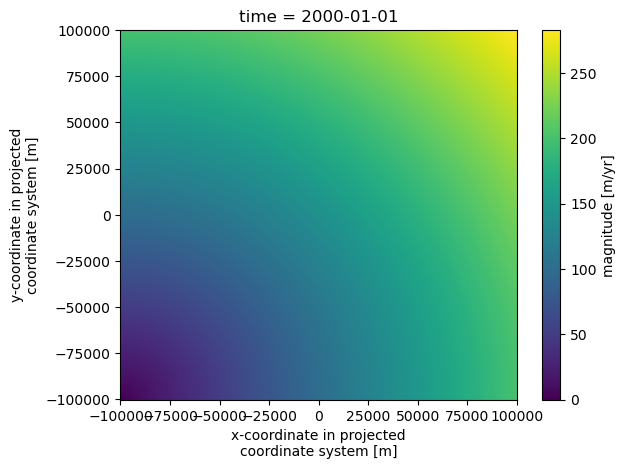

In [133]:
ds["v"].plot()

$$x(t) = x_0 + v(x) \cdot t$$
